# Convolution Neural Network Model

### Liam Kelly

In this notebook, the spectrograms which were created in the previous notebook (spectrogram_maker.ipynb) are used in a Convolution Neural Network (CNN) model. CNN models have demonstrated an excellent ability to recognize patterns in image files, which allows them to classify images with much higher accuracy than traditional classification models. 

The CNN model will be trained on a training set and its score on a validation set will be evaluated as a function of the epoch of the training. Finally, the model will evaluated through its accuracy score, confusion matrix, and precison and recall scores. 

The produced model will be saved for integration into a stramlit app.

## Importing Data

In [1]:
# Import packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

The spectrogram data must first be loaded into arrays which can be interpreted by the CNN model. We will first determine the appropriate shape of the arrays by learning the number of spectrograms in the 

In [63]:
###########################
##         Inputs       ###
###########################

folder = 'spectrogram/' # The folder where the spectrograms are contained
spec_shape = [135, 71] # The desired shape of the spectrograms (default [135,71])

###########################

i = 0 # Initialize row index

# Count the number of items:
num_items = 0
for subfolder in os.listdir(folder):
    path = folder + subfolder + '/'
    num_items += len(os.listdir(path)) # Add the number of items in the subfolder to the total number of items

print('The number of items in the %s folder is: %i' % (folder, num_items))

# Initialize X and y arrays:
X = np.empty((num_items, spec_shape[0], spec_shape[1]))   
y = []

print(f'The shape of the X array is: {X.shape}')

The number of items in the spectrogram/ folder is: 31021
The shape of the X array is: (31021, 135, 71)


Now that we have the X array and y list initialized to store the spectrograms and their labels, respectively, we can being loading the spectrograms into the arrays. The data will be scaled so that the values for each spectrogram are in the range of [0,1].

Note: the spectrograms are given in log scale. If the linear scale spectrogram contains any data points with a value of 0, these data points will become -inf in the log scale spectrograms ($log(0) = -inf$). These spectrograms will be dropped as the CNN model cannot handle inf values. Also, some spectrograms varying shapes. To maintain a constant shape for all spectrograms, spectrgrams which are larger than the desired shape will be truncated and spectrograms which are smaller will be padded with values of 0.

In [65]:
# Create the X and y arrays:
i = 0
j =0
for subfolder in os.listdir(folder): # Check each subfolder in folder
    j += 1
    path = folder + subfolder + '/'
    print('Currently loading the \033[1m%s\033[0m subfolder... (%i/%i)        ' % (subfolder, j, len(os.listdir(folder))), end = '\r')
    
    # Loop over each numpy array in the subfolder:
    for item in os.listdir(path): 
        
        # Load the spectrogram data from the current numpy array.
        data = np.load(path + item) 
        
        # Check if the data contains infinite values:
        if np.isinf(data).sum() > 0:
            X = np.delete(X, i, 0) # If infinite values, drop the row from the X array.
        
        # If no infinite values, continue processing data:
        else:
            # Scale the data so the values are between 0 and 1:
            data = data - data.min()
            data = data/data.max()
            
            # Check that the data has the correct shape:
            if data.shape != (135,71):
                
                # If the data has less rows:
                if data.shape[1] < 71:
                    X[i,:,:] = 0 # Write a basleine value of the minimum value of the array.
                    X[i,:data.shape[0], :data.shape[1]] = data # Overwrite the first values of the X array with the data from the spectrogram.
                
                # If the data has more rows:
                else:
                    X[i,:,:] = data[:135,:71] # Take only the first 135 rows and 71 columns from the data.
                    
            # If data has the correct number of rows:
            else:
                X[i,:,:] = data # Save the spectrogram data to the appropriate row in the X array.
            
            
            # Append the spoken word to the y data:
            y.append(subfolder)
        
            i += 1 # Add one to the row counter.

print('Done!                                                  ', end = '\r')

Now let's check the new shape of our X array after dropping spectrogram with inf values:

In [66]:
print(f'The shape of the X array is: {X.shape}')
print(f'The length of the y array is: {len(y)}')

The shape of the X array is: (29978, 135, 71)
The length of the y array is: 29978


## Inspect the Data

Before modelling, the data should be inspected. First, the count of samples for each class label can be visualized using a histogram:

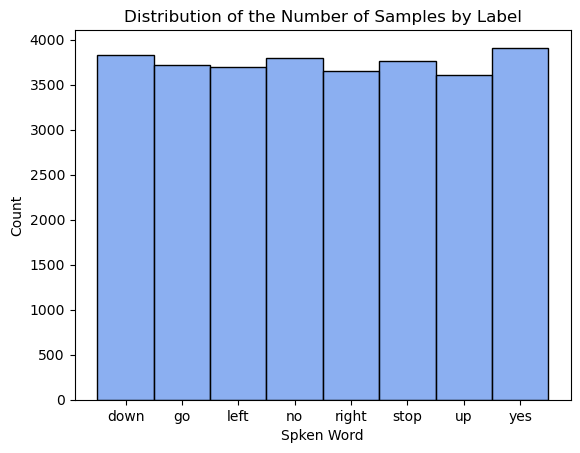

In [67]:
# Check the distribution of different spoken words:
sns.histplot(y, color = 'cornflowerblue')
plt.title('Distribution of the Number of Samples by Label')
plt.xlabel('Spken Word')
plt.show()

There's a slightly uneven distribution of samples across the different labels, which may cause our classificiant model to become slightly biased towards labels with more samples. 

To combat this, down sampling can be used to create an even distribution in the different word labels.

First the size of the smallest group must be determined:

In [68]:
from collections import Counter

# Find the minimum number of samples for a word:
min_samp = np.array(list(Counter(y).values())).min() 
print('The smallest number of samples for a word is %i' % min_samp)

The smallest number of samples for a word is 3608


Since the smallest number of samples for one word is 3723, we should reduce the number of samples for each of the other words to this same length.

In [69]:
y_ds = np.asarray(y.copy())
X_ds = X.copy()

In [70]:
word_list = np.unique(y_ds) # Create list of words
for word in word_list:
    indices = np.where( y_ds == word )[0][min_samp:]# Select the samples with indicies beyond min_samp
    y_ds = np.delete(y_ds, indices, 0)
    X_ds = np.delete(X_ds, indices, 0)

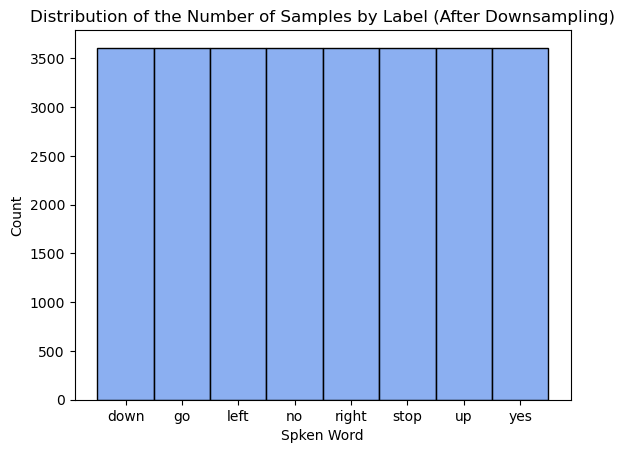

In [83]:
# Check the distribution of different spoken words:
sns.histplot(y_ds, color = 'cornflowerblue')
plt.title('Distribution of the Number of Samples by Label (After Downsampling)')
plt.xlabel('Spken Word')
plt.show()

There is now an even distribution in the number of samples by class labels. A sample spectrogram can be obtained from each class to perform a quick inspection of the data, and to see if any visual differences between classes are apparent.

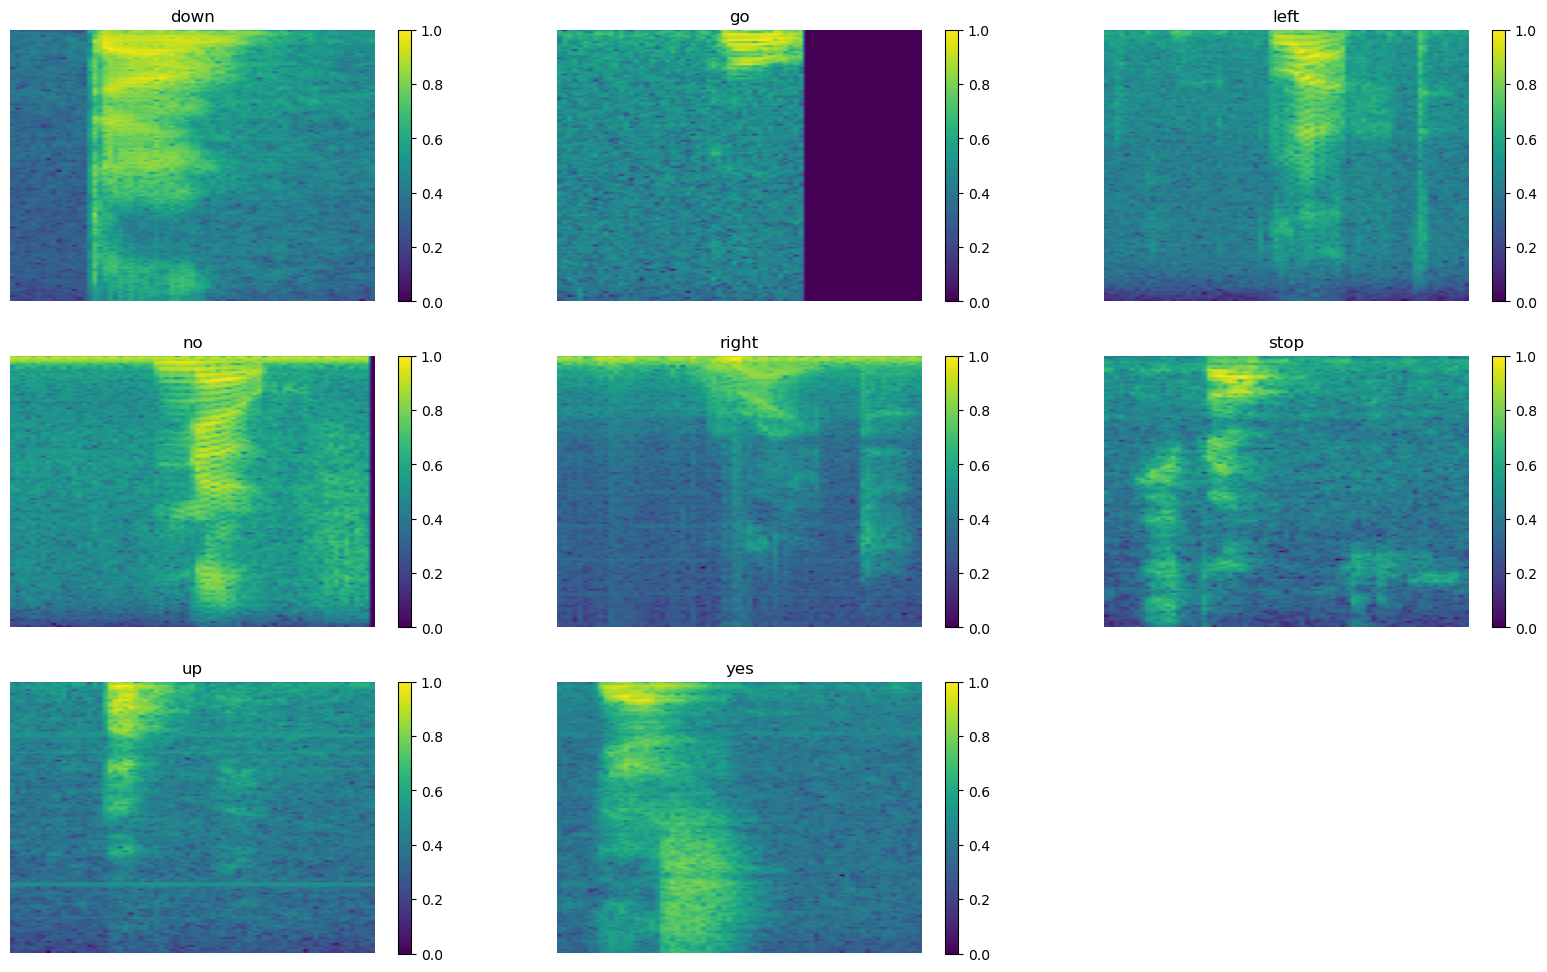

In [80]:
# Plot a sample spectrogram from each label

plt.figure(figsize=(20, 12)) # Initialize the figure.

i = 0  # Initialize the figure number counter.
for label in word_list:
        j = np.where(y_ds == label)[0][np.random.choice(np.arange(min_samp), size = 1)][0] # Choose a random index between 0 and 2000 for the given label.
        
        # Create the plot
        ax = plt.subplot(3, 3, i + 1) # Place the plot in the ith spot.
        plt.imshow(X_ds[j], aspect= 'auto') # plot the spectrogram
        plt.title(y_ds[j]) # Make the label the title.
        plt.axis("off")
        plt.colorbar() # Show the colorbar to see the magnitude fo value associated with color.
        i += 1 # Add one to the figure number counter.

plt.show() 

The images appear to be spectrograms, and the images for different words look differently. The above cell can be rerun to ramdonly sample different spectrograms.

Finally, the data must be split into training and testing sets. A test set size of 20% will be used. A label encoder will be used to convert the y labels into integer values, since the keras package requires numeric labels.

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size= 0.2)

# Encode the labels as integers
le = LabelEncoder().fit(y_train) # Initialize and fit the label encoder object
y_train = le.transform(y_train) # Transform the training labels into integers
y_test = le.transform(y_test) # Transform the testing labels into integers

# Reshape for Keras model types
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Finally, print the shape of each array:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (23091, 135, 71, 1)
y_train shape: (23091,)
X_test shape: (5773, 135, 71, 1)
y_test shape: (5773,)


## Convolution Neural Network Modelling

Since the data has been prepared for modelling, a CNN model can now be initialize and trained on the training data. First, the Keras packages should be imported to build the neaural network.

In [86]:
# Import packages:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

The CNN model is designed by using a series of sequential layers. The model starts by applying a series of convolution, max pooling, and batch normaliztion layers which help the model to identify patterns in the spectrogram images. From there the convolved filters are flattened into an array of features, the number of which are reduced by using smaller and smaller Dense layers and Dropout layers until the output layer has the correct number of classes (8).

In [87]:
# Initalize the CNN model:
CNN_model = Sequential()
num_classes = len(set(y_train)) # Specifiy tyhe number of classes for the output layer

# Create simple CNN model architecture that uses several convolution, max pooling, and batch normalization layers:
CNN_model.add(Conv2D(filters = 32, kernel_size=(3, 3), activation = 'relu', input_shape = (spec_shape[0], spec_shape[1], 1)))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(BatchNormalization())
CNN_model.add(Conv2D(filters = 64, kernel_size=(3, 3), activation = 'relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(BatchNormalization())
CNN_model.add(Conv2D(filters = 128, kernel_size=(3, 3), activation = 'relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(BatchNormalization())
CNN_model.add(Conv2D(filters = 256, kernel_size=(3, 3), activation = 'relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.25))

# Flatten the output of the convolution layers
CNN_model.add(Flatten())

# Add dense and dropout layers to reduce the number of nodes:
CNN_model.add(Dense(512, activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(64, activation = 'relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(Dense(num_classes, activation='softmax'))

# Print out a summary of the network
CNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 133, 69, 32)       320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 66, 34, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 66, 34, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 32, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 16, 64)       0         
 g2D)                                                            
                                                      

In [88]:
# Compile the model and specify the desired loss metric, optimizer and succes metric:
CNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

**WARNING:** The following cell takes long to run:

In [89]:
# Fit the model to the training data. Specifiy the batch size, number of epochs, and validation set size.
history = CNN_model.fit(X_train, y_train,
              batch_size = 32,
              epochs = 20,
              verbose = 1,
              validation_split = 0.2)

Epoch 1/20
578/578 [==============================] - 124s 208ms/step - loss: 1.0632 - accuracy: 0.6212 - val_loss: 1.1862 - val_accuracy: 0.5733
Epoch 2/20
578/578 [==============================] - 127s 220ms/step - loss: 0.4974 - accuracy: 0.8273 - val_loss: 0.4057 - val_accuracy: 0.8649
Epoch 3/20
578/578 [==============================] - 124s 215ms/step - loss: 0.3467 - accuracy: 0.8800 - val_loss: 0.6293 - val_accuracy: 0.7744
Epoch 4/20
578/578 [==============================] - 115s 199ms/step - loss: 0.2861 - accuracy: 0.9022 - val_loss: 0.4664 - val_accuracy: 0.8402
Epoch 5/20
578/578 [==============================] - 112s 194ms/step - loss: 0.2273 - accuracy: 0.9220 - val_loss: 0.3031 - val_accuracy: 0.8950
Epoch 6/20
578/578 [==============================] - 115s 199ms/step - loss: 0.2071 - accuracy: 0.9291 - val_loss: 0.5066 - val_accuracy: 0.8296
Epoch 7/20
578/578 [==============================] - 127s 220ms/step - loss: 0.1726 - accuracy: 0.9415 - val_loss: 0.6133 -

Now that the model has been fitted, we can visualize how the train and validation sets loss and accuracy evolved with the epoch number. This will indicate whether or not enough training has been done, or if the model has overfitted to the training data.

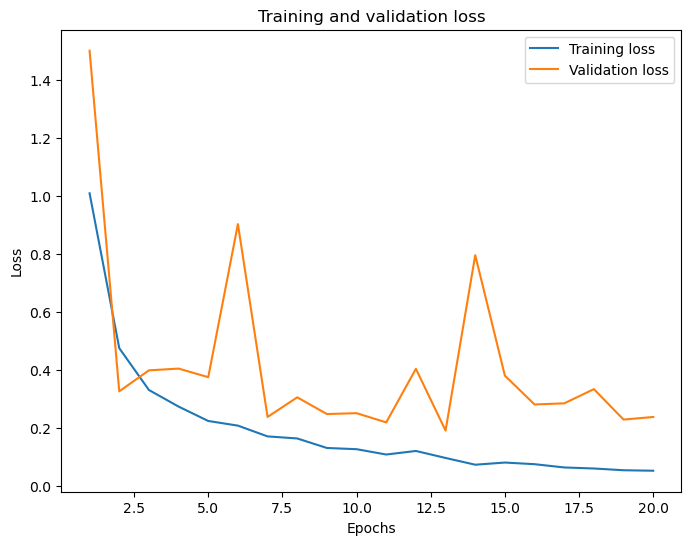

In [45]:
# Get the history data for the loss:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

# Plot a line plot for both the training and validation loss:
plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values,  label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The validation loss drops quickly between the 1st and second epoch, and continues to trend downwards until the 20th epoch. Training loss decreases exponentially with epoch number.

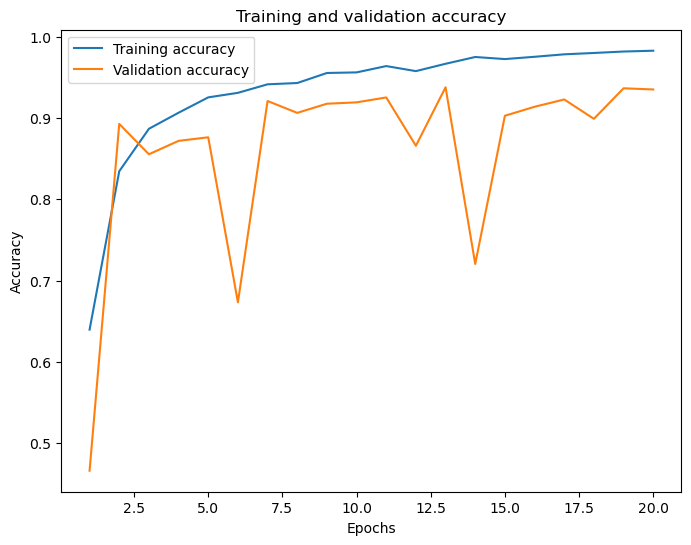

In [46]:
# Get the history data for the accuracy:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

# Plot a line plot for both the training and validation accuracy:
plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, label='Training accuracy')
plt.plot(epochs, val_acc_values, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Similar to the loss, validation accuracu imporves drastically between the 1st and 2nd epoch, then slowly trends upwards until the 20th epoch. Training accuracy increases logarithmically with epoch. The 20th epoch seems to be a good place to stop, validation and training accuracy seem to be reaching a steady state, and futher epochs may lead to overfitting.

## Model Evaluation

The model can now be evaluated from its accuracy score, confusion matrix, and its precision and recall scores. 

Starting with the accuracy score:

In [47]:
# Evaluate the model's performance on the test data
score = CNN_model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

188/188 [==============================] - 10s 54ms/step - loss: 0.2332 - accuracy: 0.9346
Test loss: 0.23315083980560303
Test accuracy: 0.9346230626106262


The CNN model demonstrates exceptional accuracy on the test set of 93.5%, which is much better than the XGBoost model whose accuracy was about 50%. 

We can also look at the confusion matrix:

In [92]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
# Calculate the predicted values:
y_pred = CNN_model.predict(X_test).argmax(axis = 1) # Take the argmax as each predicted values in an array with the confindence for each label.

# Calculate the confusion matrix:
matrix = confusion_matrix(y_test, y_pred)

181/181 [==============================] - 9s 51ms/step


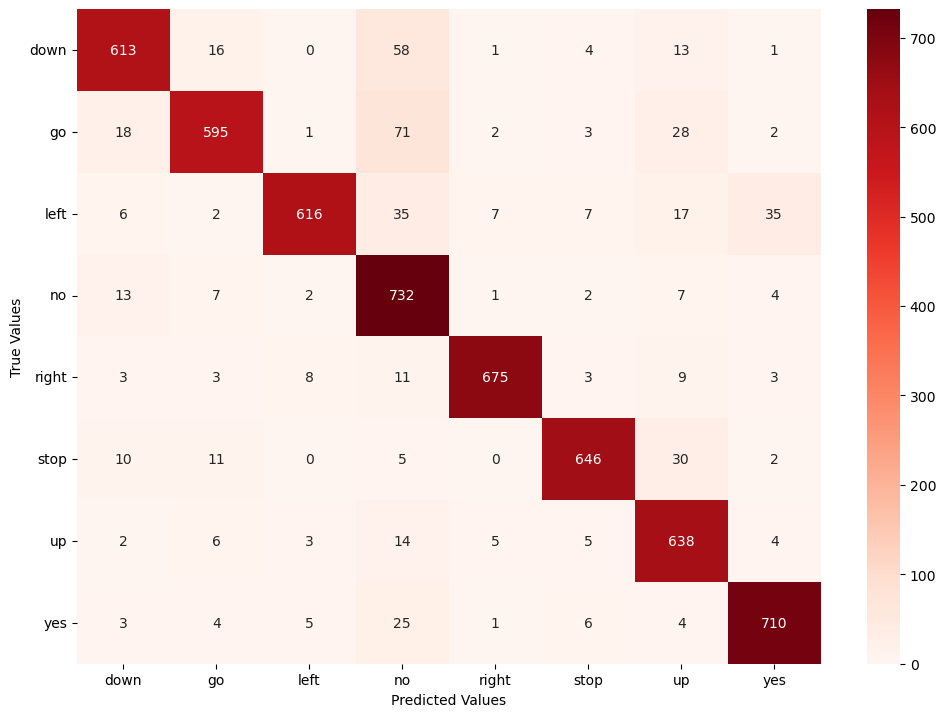

In [99]:
# Plot the confusion matrix:
plt.figure(figsize = (12, 8.5))
sns.heatmap(matrix, cmap = 'Reds', annot = True, fmt = 'g')
plt.yticks(ticks = np.array(range(8)) + 0.5, labels = le.inverse_transform(np.arange(8)), rotation = 00)
plt.xticks(ticks = np.array(range(8)) + 0.5, labels = le.inverse_transform(np.arange(8)))
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

The data is remarkably well confined along the diagonal, with the most substantial misclassification being predicted no when the true value is down, which occurs over 10 x less frequently than the model predicts the true value of down. To further break down the models performance on specific words, we can look at the precision and recall:

[3 0 7 ... 1 4 2]


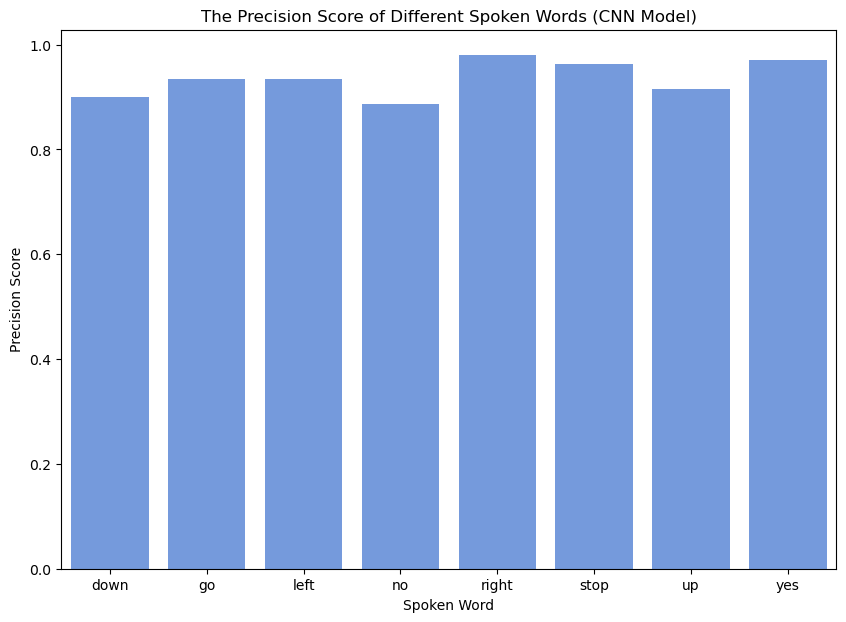

The precision of all labels combined is: 0.935


In [56]:
# Calculate and visualize the precision.
from sklearn.metrics import precision_score
print(y_test)

# Calculate the precision score for each label:
pre_score =  precision_score(y_test, y_pred, average = None)

# Visualize the precision score for each label:
plt.figure(figsize = (10,7))
sns.barplot(x = le.inverse_transform(range(8)), y = pre_score, color = 'cornflowerblue')
plt.xlabel('Spoken Word')
plt.ylabel('Precision Score')
plt.title('The Precision Score of Different Spoken Words (CNN Model)')
plt.show()

# Print the overall precision score:
print('The precision of all labels combined is: %.3f' % precision_score(y_test, y_pred, average = 'micro'))

When compared to the XGBoost model, the CNN demonstrates superior precision accross the board. The precision is also much more consistent between different words for the CNN model. Finally the recall can be investigated:

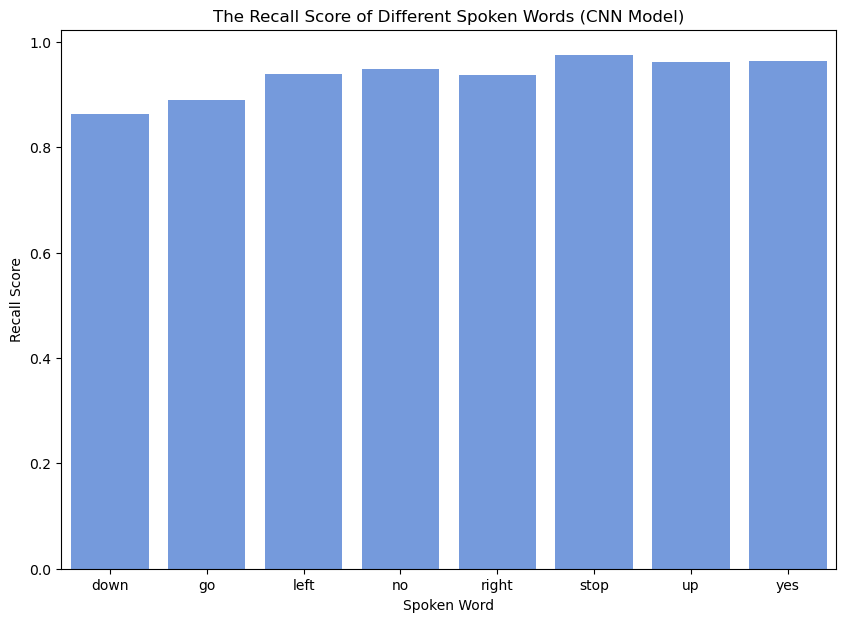

The recall of all labels combined is: 0.935


In [58]:
# Calculate and visualize the recall.
from sklearn.metrics import recall_score

# Calculate the recall score for each label:
rec_score =  recall_score(y_test, y_pred, average = None)

# Visualize the recall score for each label:
plt.figure(figsize = (10,7))
sns.barplot(x = le.inverse_transform(range(8)), y = rec_score, color = 'cornflowerblue')
plt.xlabel('Spoken Word')
plt.ylabel('Recall Score')
plt.title('The Recall Score of Different Spoken Words (CNN Model)')
plt.show()

# Print the overall recall score:
print('The recall of all labels combined is: %.3f' % recall_score(y_test, y_pred, average = 'micro'))

Again the CNN model has much better recall than the XGBoost model, and also shows more consistent performance when comparing different words.

Finally, the weights for this model can be saved along with the label encoder for use in a streamlit app:

In [100]:
# save the classifier and scaler
CNN_model.save_weights('models/cnn_weights')
pickle.dump(le, open('models/label_encoder_cnn.sav', 'wb'))